# Analysis of the synthetic data (Hagmann 66 x 66 matrix) model-fitting

Approximate run duration: < 10 seconds

The model-fitting methods on the data from the synthetic data let us view how well the parameters fit the model. This one's using the data from Hagmann et al., 2008. 

After fitting the model to the empirical BOLD signal, one may get a set of model parameters that fit the model well. We can use the forward model and the fitted model parameters to generate simulated BOLD data, fit the model again to the simulated BOLD signal with the fitted model parameters (true values), and the new model-fitted data are saved at the files with the `idt` suffix. 

In this analysis, we demonstrate how well they fit.

## Setup

In [1]:
import matplotlib.pyplot as plt # for plotting 
import numpy as np # for numerical operations 
import pandas as pd # for data manipulation 
import seaborn as sns # for plotting
import time # for timing the results
import warnings # for suppressing warnings and output
warnings.filterwarnings('ignore')

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
cd /content/drive/MyDrive/Work/Sciencing/Google_CoLab_projects/WWD_Model/WWD_pytorch/wwd-model-fitting/final/

/content/drive/MyDrive/Work/Sciencing/Google_CoLab_projects/WWD_Model/WWD_pytorch/wwd-model-fitting/final


In [4]:
start_time = time.time()

In [5]:
mask = np.tril_indices(66,-1)

In [16]:
base_dir = '../data/Hagmann/'
ts_file = base_dir+'syn_ts.txt'
        
#SC = np.loadtxt(SC_file)
ts = np.loadtxt(ts_file)
print(ts.shape)
sc_file = base_dir + 'weights.txt'

sc = np.loadtxt(sc_file)
sc = (sc + sc.T)*0.5 
SC = sc - np.diag(np.diag(sc))
#SC[SC <SC[SC>0].mean() + 1.*SC[SC>0].std()] = 0
sc_true = np.log1p(SC)/np.linalg.norm(np.log1p(SC)) #SC/np.linalg.norm(SC)  
fc_true = np.corrcoef(ts[2400:3600,:].T)
fc_cross = np.corrcoef(ts[0:2400,:].T)

(4800, 66)


Plot the matrices and observe the structural strength connections.

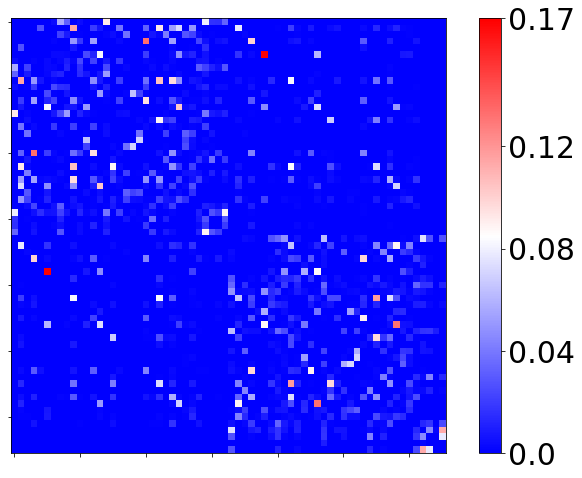

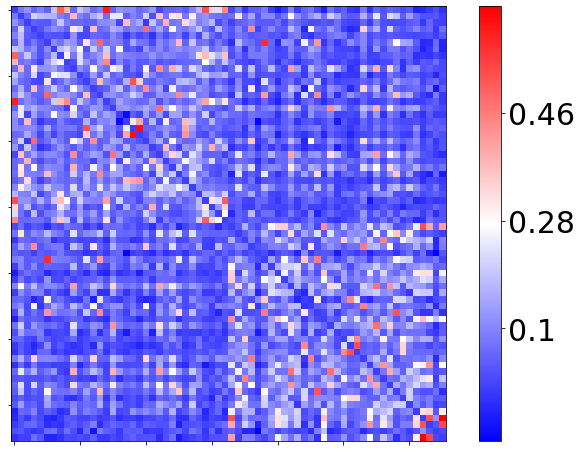

In [7]:
fig, ax = plt.subplots(1,1, figsize=(12,8))
im = ax.imshow(sc_true, cmap='bwr')
mn = round(sc_true.min(),2)
mx = round(sc_true.max(), 2)
md = round((mx + mn)/2, 2)
mnd = round((md + mn)/2, 2)
mxd = round((mx + md)/2, 2)
cbar = plt.colorbar(im, ax=ax)
cbar.ax.tick_params(labelsize=30)
cbar.set_ticks([mn,mnd, md,mxd, mx])
cbar.set_ticklabels([mn,mnd, md,mxd, mx])
ax.set_xticklabels([])
ax.set_yticklabels([])
plt.show()
# plt.savefig(base_dir+'Syn_sc_true.png')

fig, ax = plt.subplots(1,1, figsize=(12,8))
fc_nd = fc_true - np.diag(np.diag(fc_true))
im = ax.imshow(fc_nd, cmap='bwr')
mn = round(fc_nd.min(),2)
mx = round(fc_nd.max(), 2)
md = round((mx + mn)/2, 2)
mnd = round((md + mn)/2, 2)
mxd = round((mx + md)/2, 2)
cbar = plt.colorbar(im, ax=ax)
cbar.ax.tick_params(labelsize=30)
cbar.set_ticks([mn,mnd, md,mxd, mx])
cbar.set_ticklabels([mn,mnd, md,mxd, mx])
ax.set_xticklabels([])
ax.set_yticklabels([])
plt.show()
# plt.savefig(base_dir+'Syn_fc_true.png')

## Load the variables

In [8]:
### Read the model-fitting data with gains
base_dir = '../data/Hagmann/'
ts_sim_file = base_dir + 'Syn_ts_sim.npy'
ts_test_file = base_dir + 'Syn_ts_test.npy'
sc_mod_file = base_dir + 'Syn_sc_mod.npy'
sc_file = base_dir + 'Syn_sc.npy'
paras_file = base_dir + 'Syn_fitparas.npy'

Syn_ts_sim_data = np.load(ts_sim_file, allow_pickle=True)
Syn_ts_test_data = np.load(ts_test_file, allow_pickle=True)
Syn_sc_mod_data = np.load(sc_mod_file, allow_pickle=True)
Syn_sc_data = np.load(sc_file, allow_pickle=True)
Syn_para_data = np.load(paras_file, allow_pickle=True)

Syn_ts_test = Syn_ts_test_data.item()
Syn_ts_sim = Syn_ts_sim_data.item()
Syn_sc_mod = Syn_sc_mod_data.item()
Syn_sc = Syn_sc_data.item()
Syn_paras = Syn_para_data.item()

## Histogram plots of parameter-fitting

How well do the parameters fit to the model? Test how much error there is for each parameter value that can be fit. Plot the distribution of these erorrs across subjects for the four parameters. 

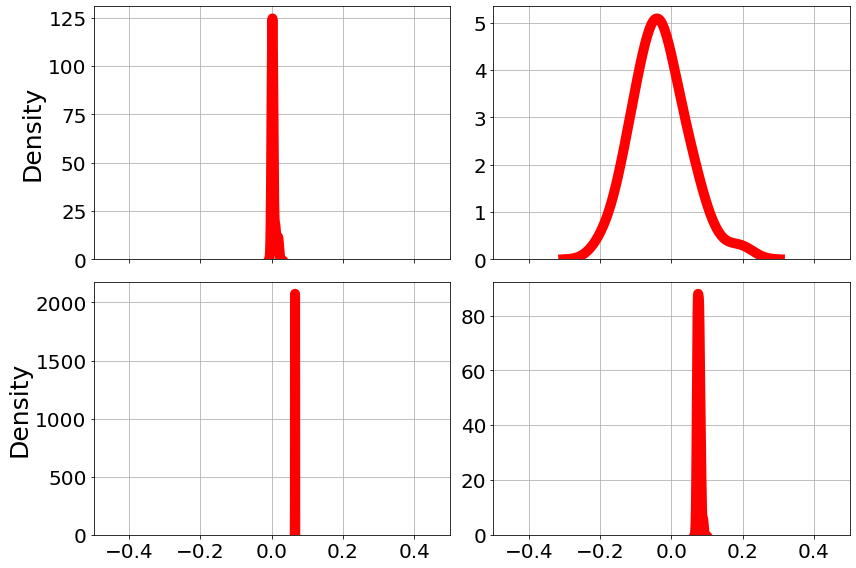

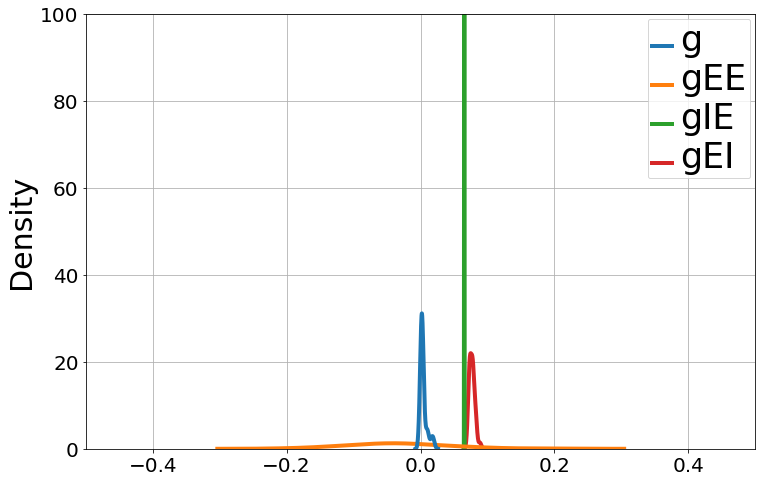

In [11]:
start_time = time.time()
fig, ax = plt.subplots(2,2, figsize=(12,8), sharex=True)
plt.rcParams["axes.labelsize"] = 30
mask = np.tril_indices(66,-1)
data_dict = {}
data_max = {}
data_dict['g'] = []
data_dict['gEE'] = []
data_dict['gIE'] = []
data_dict['gEI'] = []

data_max['g'] = []
data_max['gEE'] = []
data_max['gIE'] = []
data_max['gEI'] = []

"""
Across the test subjects, take the maximum of the absolute value of the mean of the parameter 
values identified for the model and the same for the parameter values. Append the two values and 
add them to the `data_max` dictionary for the coupling strength parameters. 
"""

para_name = ['g', 
             'gEE', 
             'gIE', 
             'gEI']

for sub in Syn_paras:
    
    data_max['g'].append(max(np.abs(Syn_paras[sub][0].mean()), 100))
    data_max['gEE'].append(max(np.abs(Syn_paras[sub][1].mean()), 3.5))
    data_max['gIE'].append(max(np.abs(Syn_paras[sub][2].mean()), 0.42))
    data_max['gEI'].append(max(np.abs(Syn_paras[sub][3].mean()), 0.42))
         
"""
Take these parameter values and use these maximum values to normalize the range of parameter values. 
"""

for sub in Syn_paras:
    
    data_dict['g'].append((Syn_paras[sub][0].mean() - 100)/max(data_max['g']))
    data_dict['gEE'].append((Syn_paras[sub][1].mean() - 3.5)/max(data_max['gEE']))
    data_dict['gIE'].append((Syn_paras[sub][2].mean() - 0.42)/max(data_max['gIE']))
    data_dict['gEI'].append((Syn_paras[sub][3].mean() - 0.42)/max(data_max['gEI']))
    
data_dict['g'] = np.array(data_dict['g'])
data_dict['gEE'] = np.array(data_dict['gEE'])
data_dict['gIE'] = np.array(data_dict['gIE'])
data_dict['gEI'] = np.array(data_dict['gEI'])

"""
Plot the results.
"""

for i in range(4):
    sns.kdeplot(ax=ax[i//2, i%2], data=data_dict[para_name[i]], color= 'r', linewidth=10)
    #ax[i//2, i%2].set_title('hist of error of ' + para_name[i] +' across subjects', fontsize = 20)
    ax[i//2, i%2].set_xlim(-0.5,0.5)
    ax[i//2, i%2].tick_params(labelsize = 20)
    ax[i//2, i%2].grid()
    if i%2 == 1:
        ax[i//2, i%2].set_ylabel('')
fig.tight_layout()
plt.show()
# fig.savefig(base_dir + 'Syn_hist_modelparaserror_normalized.png')

fig, ax = plt.subplots(1,1, figsize=(12,8))
plt.rcParams["axes.labelsize"] = 25
sns.kdeplot(data= pd.DataFrame(data_dict), linewidth =4)
#ax.set_title('hist of error of parameters across subjects', fontsize =25)
ax.tick_params(labelsize= 20)
ax.set_xlim(-0.5,0.5)
ax.set_ylim(0,100)
ax.grid()
plt.setp(ax.get_legend().get_texts(), fontsize='35')
plt.setp(ax.get_legend().get_title(), fontsize ='50')
plt.show()
# fig.savefig(base_dir+'Syn_hist_modelparaserror_normalized_in1fig.png')

[None, None]

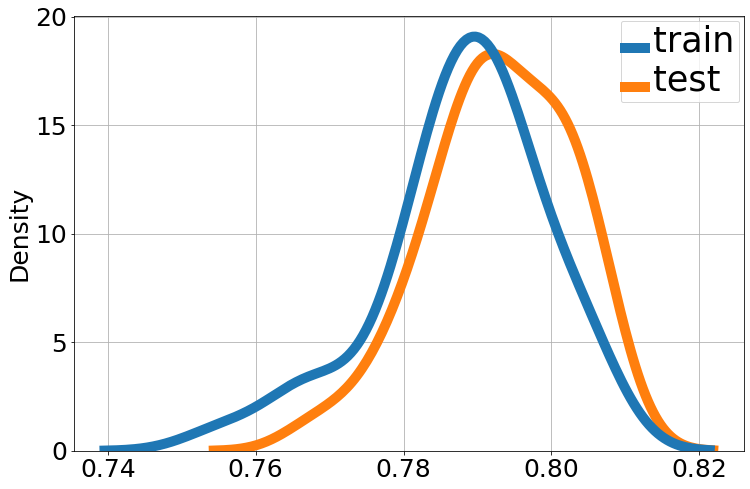

In [12]:
start_time = time.time()
# plot hist of r: model fitting with gains
mask = np.tril_indices(66,-1)
corr_sim ={}
r =[]
r1 =[]
for sub in Syn_ts_sim:
    r.append(np.corrcoef(fc_true[mask], np.corrcoef(Syn_ts_sim[sub])[mask])[0,1])
    r1.append(np.corrcoef(fc_true[mask], np.corrcoef(Syn_ts_test[sub])[mask])[0,1])
corr_sim['train'] = np.array(r)
corr_sim['test'] = np.array(r1)
fig, ax = plt.subplots(1,1, figsize=(12,8))
plt.rcParams["axes.labelsize"] = 35
sns.kdeplot(data = corr_sim, linewidth = 10)
#ax.set_title('hist of Pearlson correlation between the fitting and empirical BOLD', fontsize =20)
ax.tick_params(labelsize= 25)
ax.grid()

plt.setp(ax.get_legend().get_texts(), fontsize='35')
plt.setp(ax.get_legend().get_title(), fontsize ='50')

[None, None]

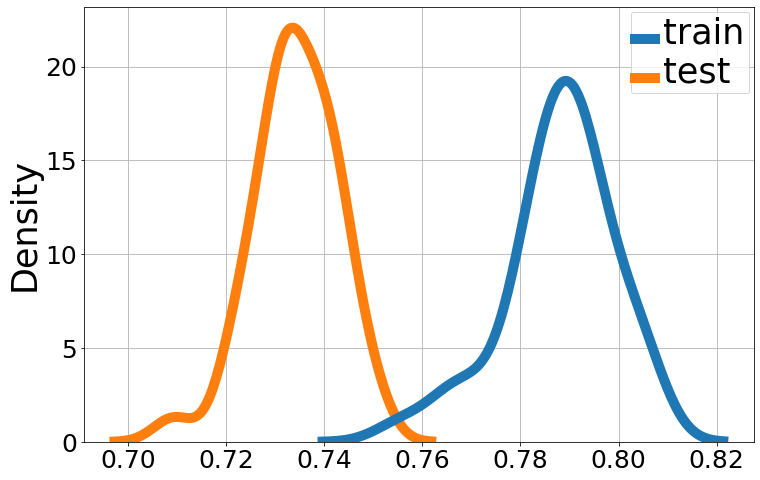

In [17]:
start_time = time.time()
# plot hist of r: model fitting with gains
mask = np.tril_indices(66,-1)
corr_sim ={}
r =[]
r1 =[]
for sub in Syn_ts_sim:
    r.append(np.corrcoef(fc_true[mask], np.corrcoef(Syn_ts_sim[sub][:,10:])[mask])[0,1])
    r1.append(np.corrcoef(fc_cross[mask], np.corrcoef(Syn_ts_test[sub])[mask])[0,1])
corr_sim['train'] = np.array(r)
corr_sim['test'] = np.array(r1)
fig, ax = plt.subplots(1,1, figsize=(12,8))
plt.rcParams["axes.labelsize"] = 35
sns.kdeplot(data = corr_sim, linewidth = 10)
#ax.set_title('hist of Pearlson correlation between the fitting and empirical BOLD', fontsize =20)
ax.tick_params(labelsize= 25)
ax.grid()

plt.setp(ax.get_legend().get_texts(), fontsize='35')
plt.setp(ax.get_legend().get_title(), fontsize ='50')

## Structural connectivity matrices

[None, None]

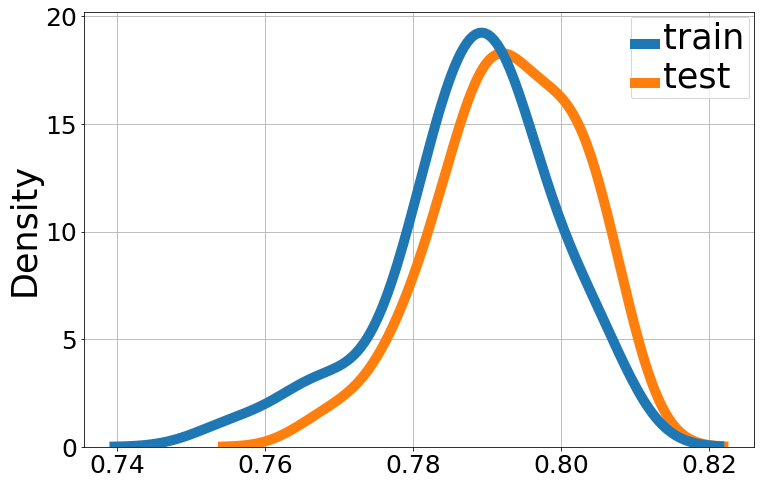

In [18]:
start_time = time.time()
# plot hist of r: model fitting with gains
mask = np.tril_indices(66,-1)
corr_sim ={}
r =[]
r1 =[]
for sub in Syn_ts_sim:
    r.append(np.corrcoef(fc_true[mask], np.corrcoef(Syn_ts_sim[sub][:,10:])[mask])[0,1])
    r1.append(np.corrcoef(fc_true[mask], np.corrcoef(Syn_ts_test[sub])[mask])[0,1])
corr_sim['train'] = np.array(r)
corr_sim['test'] = np.array(r1)
fig, ax = plt.subplots(1,1, figsize=(12,8))
plt.rcParams["axes.labelsize"] = 35
sns.kdeplot(data = corr_sim, linewidth = 10)
#ax.set_title('hist of Pearlson correlation between the fitting and empirical BOLD', fontsize =20)
ax.tick_params(labelsize= 25)
ax.grid()

plt.setp(ax.get_legend().get_texts(), fontsize='35')
plt.setp(ax.get_legend().get_title(), fontsize ='50')

# plt.savefig(base_dir+'Syn_hist_fittingcorrelation.png')

## Structural connectivity matrices

Different methods of measuring structural connectivity are shown. When testing the model-fitting analyses on different ways of measuring structural connectivity. 

They measure structural connectivity with a: 

1. `diagrandSClmtd`: uniform random value (0-1) for each weight 
2. `randSClmtd`: uniform random on the non-zero weights of the true values of structural connectivity
3. `randSC`: uniform random value on the non-zero weights of the true structural connectivity values with a second diagonal
4. `dist`: a reciprocal of distance 

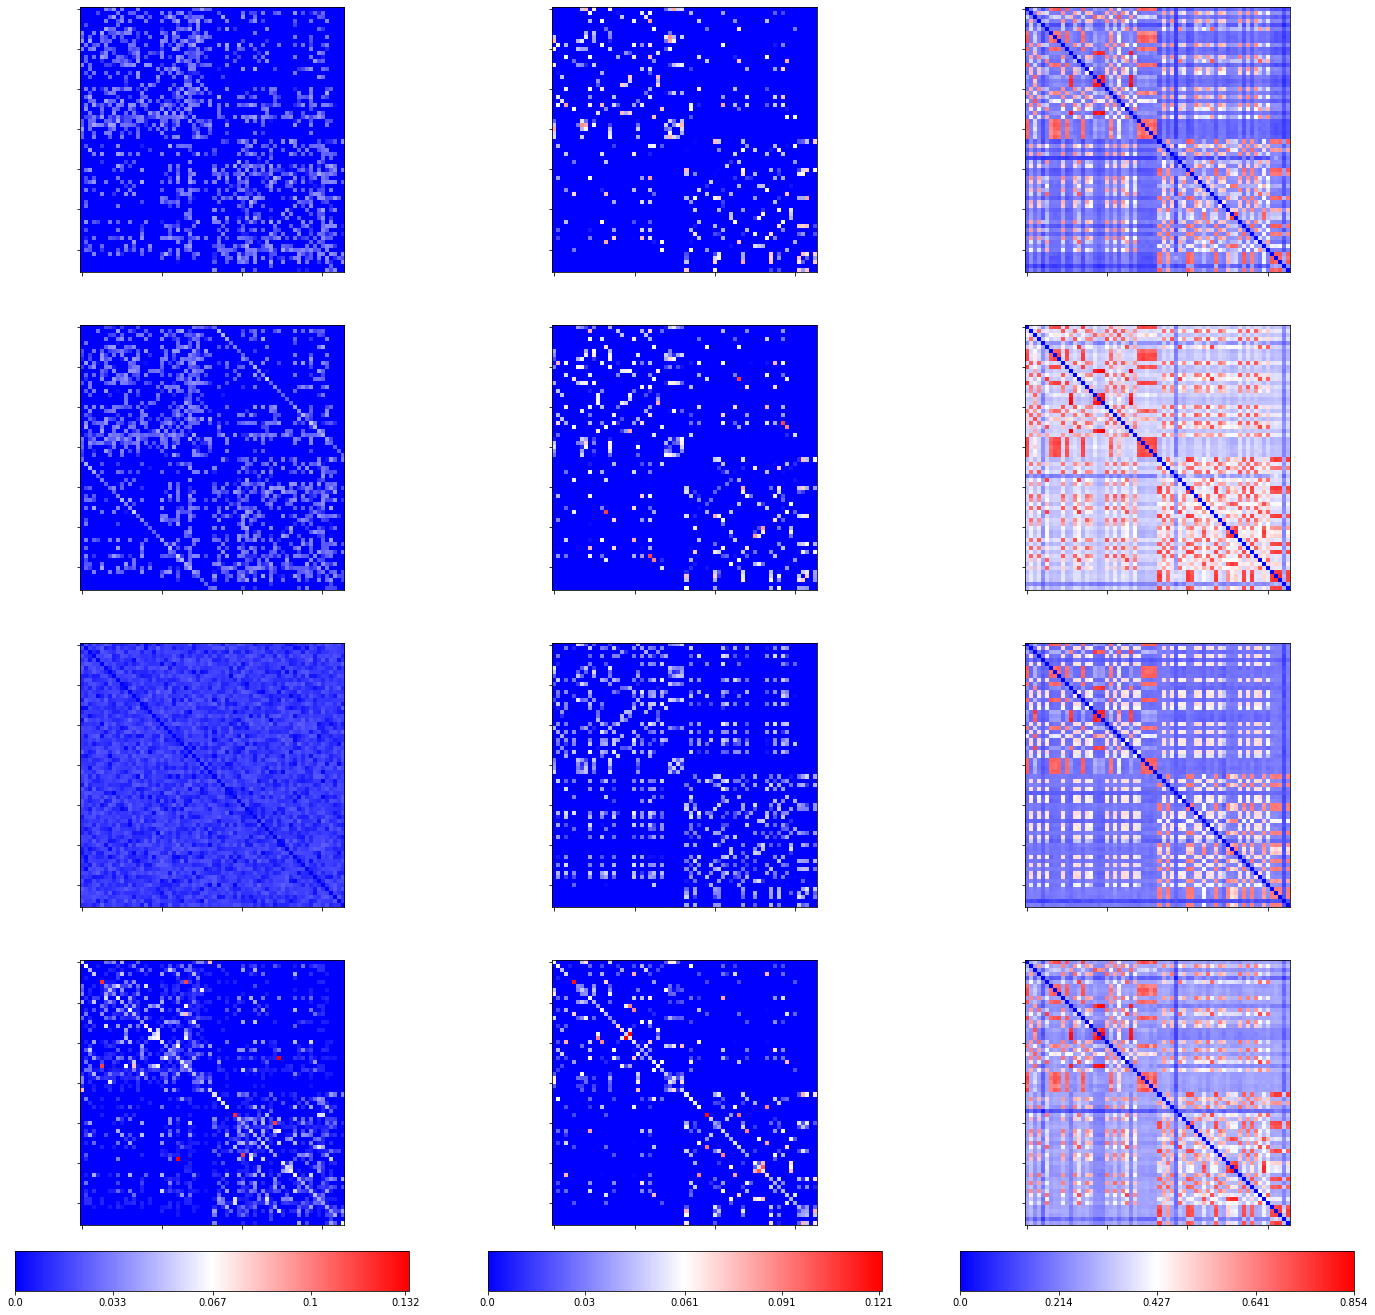

In [ ]:
start_time = time.time()
mask = np.tril_indices(66,-1)
subs = ['randSClmtd', 
        'diagrandSClmtd', 
        'randSC', 
        'dist']

titles = ['RandNonzeros', 
          'RandNonzeroes+diag', 
          'Rand', 
          'DistRecp']

sc_diff_file = base_dir + 'Syn_diff_sc.npy'
fc_diff_sim_file = base_dir + 'Syn_diff_fc_sim.npy'
sc_diff_mod_file = base_dir + 'Syn_diff_sc_mod.npy'

Syn_diff_sc_data = np.load(sc_diff_file, allow_pickle=True)
Syn_diff_fc_sim_data = np.load(fc_diff_sim_file, allow_pickle=True)
Syn_diff_sc_mod_data = np.load(sc_diff_mod_file, allow_pickle=True)
Syn_diff_sc = Syn_diff_sc_data.item()
Syn_diff_fc_sim = Syn_diff_fc_sim_data.item()

Syn_diff_sc_mod = Syn_diff_sc_mod_data.item()
vmax_ls = [0,0,0]
vmin_ls = [1,1,1]
delta = np.array([0,0,0,0,-0.001])
i = 0
for sub in Syn_diff_sc_mod:
  if i < 4:
      
      if Syn_diff_sc[sub].max() > vmax_ls[0]:
          vmax_ls[0] = Syn_diff_sc[sub].max()
      if Syn_diff_sc_mod[sub].max() > vmax_ls[1]:
          vmax_ls[1] = Syn_diff_sc_mod[sub].max()
      if (Syn_diff_fc_sim[sub]- np.diag(np.diag(Syn_diff_fc_sim[sub]))).max() > vmax_ls[2]:
          vmax_ls[2] = (Syn_diff_fc_sim[sub]- np.diag(np.diag(Syn_diff_fc_sim[sub]))).max()

      if Syn_diff_sc[sub].min() < vmin_ls[0]:
          vmin_ls[0] = Syn_diff_sc[sub].min()
      if Syn_diff_sc_mod[sub].min() < vmin_ls[1]:
          vmin_ls[1] = Syn_diff_sc_mod[sub].min()
      if (Syn_diff_fc_sim[sub]- np.diag(np.diag(Syn_diff_fc_sim[sub]))).min() < vmin_ls[2]:
          vmin_ls[2] = (Syn_diff_fc_sim[sub]- np.diag(np.diag(Syn_diff_fc_sim[sub]))).min()
      i += 1
fig, ax = plt.subplots(4, 3, figsize=(24,24))
i = 0
for sub in Syn_diff_sc_mod:
  if i < 4:
      
      im0 = ax[i,0].imshow(Syn_diff_sc[sub], cmap='bwr', vmax = vmax_ls[0], vmin=vmin_ls[0])
      im1 = ax[i,1].imshow(Syn_diff_sc_mod[sub], cmap='bwr', vmax = vmax_ls[1], vmin=vmin_ls[1])
      im2 = ax[i,2].imshow(Syn_diff_fc_sim[sub] - np.diag(np.diag(Syn_diff_fc_sim[sub])), cmap='bwr', vmax = vmax_ls[2], vmin=vmin_ls[2])
          
      #ax[i,0].set_title(titles[i] +': initial SC', fontsize= 20)
      ax[i,0].tick_params(labelsize= 15)
      #ax[i,0].tick_params(axis='y', labelsize= 15)
      #ax[i,1].set_title(titles[i] +': modified SC', fontsize= 20)
      ax[i,1].tick_params(labelsize= 15)
      #ax[i,1].tick_params(axis='y', labelsize= 15)
      #ax[i,2].set_title(sub +': sim FC', fontsize= 20)
      ax[i,2].tick_params(labelsize= 15)#
      #ax[i,2].tick_params(axis='y', labelsize= 15)
      ax[i,0].set_xticklabels([])
      ax[i,0].set_yticklabels([])
      ax[i,1].set_xticklabels([])
      ax[i,1].set_yticklabels([])
      ax[i,2].set_xticklabels([])
      ax[i,2].set_yticklabels([])
      i += 1
  else:
    break
cbar0 = fig.colorbar(im0, ax = ax.T[0],  location='bottom', aspect=10, fraction = 0.046, pad = 0.02)
cbar0.set_ticks(delta+np.round(np.linspace(vmin_ls[0], vmax_ls[0], 5), 3))
cbar0.set_ticklabels(delta+ np.round(np.linspace(vmin_ls[0], vmax_ls[0], 5),3))

cbar1 = fig.colorbar(im1, ax = ax.T[1],  location='bottom', aspect=10,fraction = 0.046, pad = 0.02)
cbar1.set_ticks(delta+np.round(np.linspace(vmin_ls[1], vmax_ls[1], 5), 3))
cbar1.set_ticklabels(delta+np.round(np.linspace(vmin_ls[1], vmax_ls[1], 5), 3))

cbar2 = fig.colorbar(im2, ax = ax.T[2],  location='bottom',  aspect=10,fraction = 0.046, pad = 0.02)
cbar2.set_ticks(delta+np.round(np.linspace(vmin_ls[2], vmax_ls[2], 5), 3))
cbar2.set_ticklabels(delta+np.round(np.linspace(vmin_ls[2], vmax_ls[2], 5),3))
plt.show()
# fig.savefig(base_dir+'Syn_sc_bestfit_differentInits.png')

## Histograms of parameter fitting across subjects

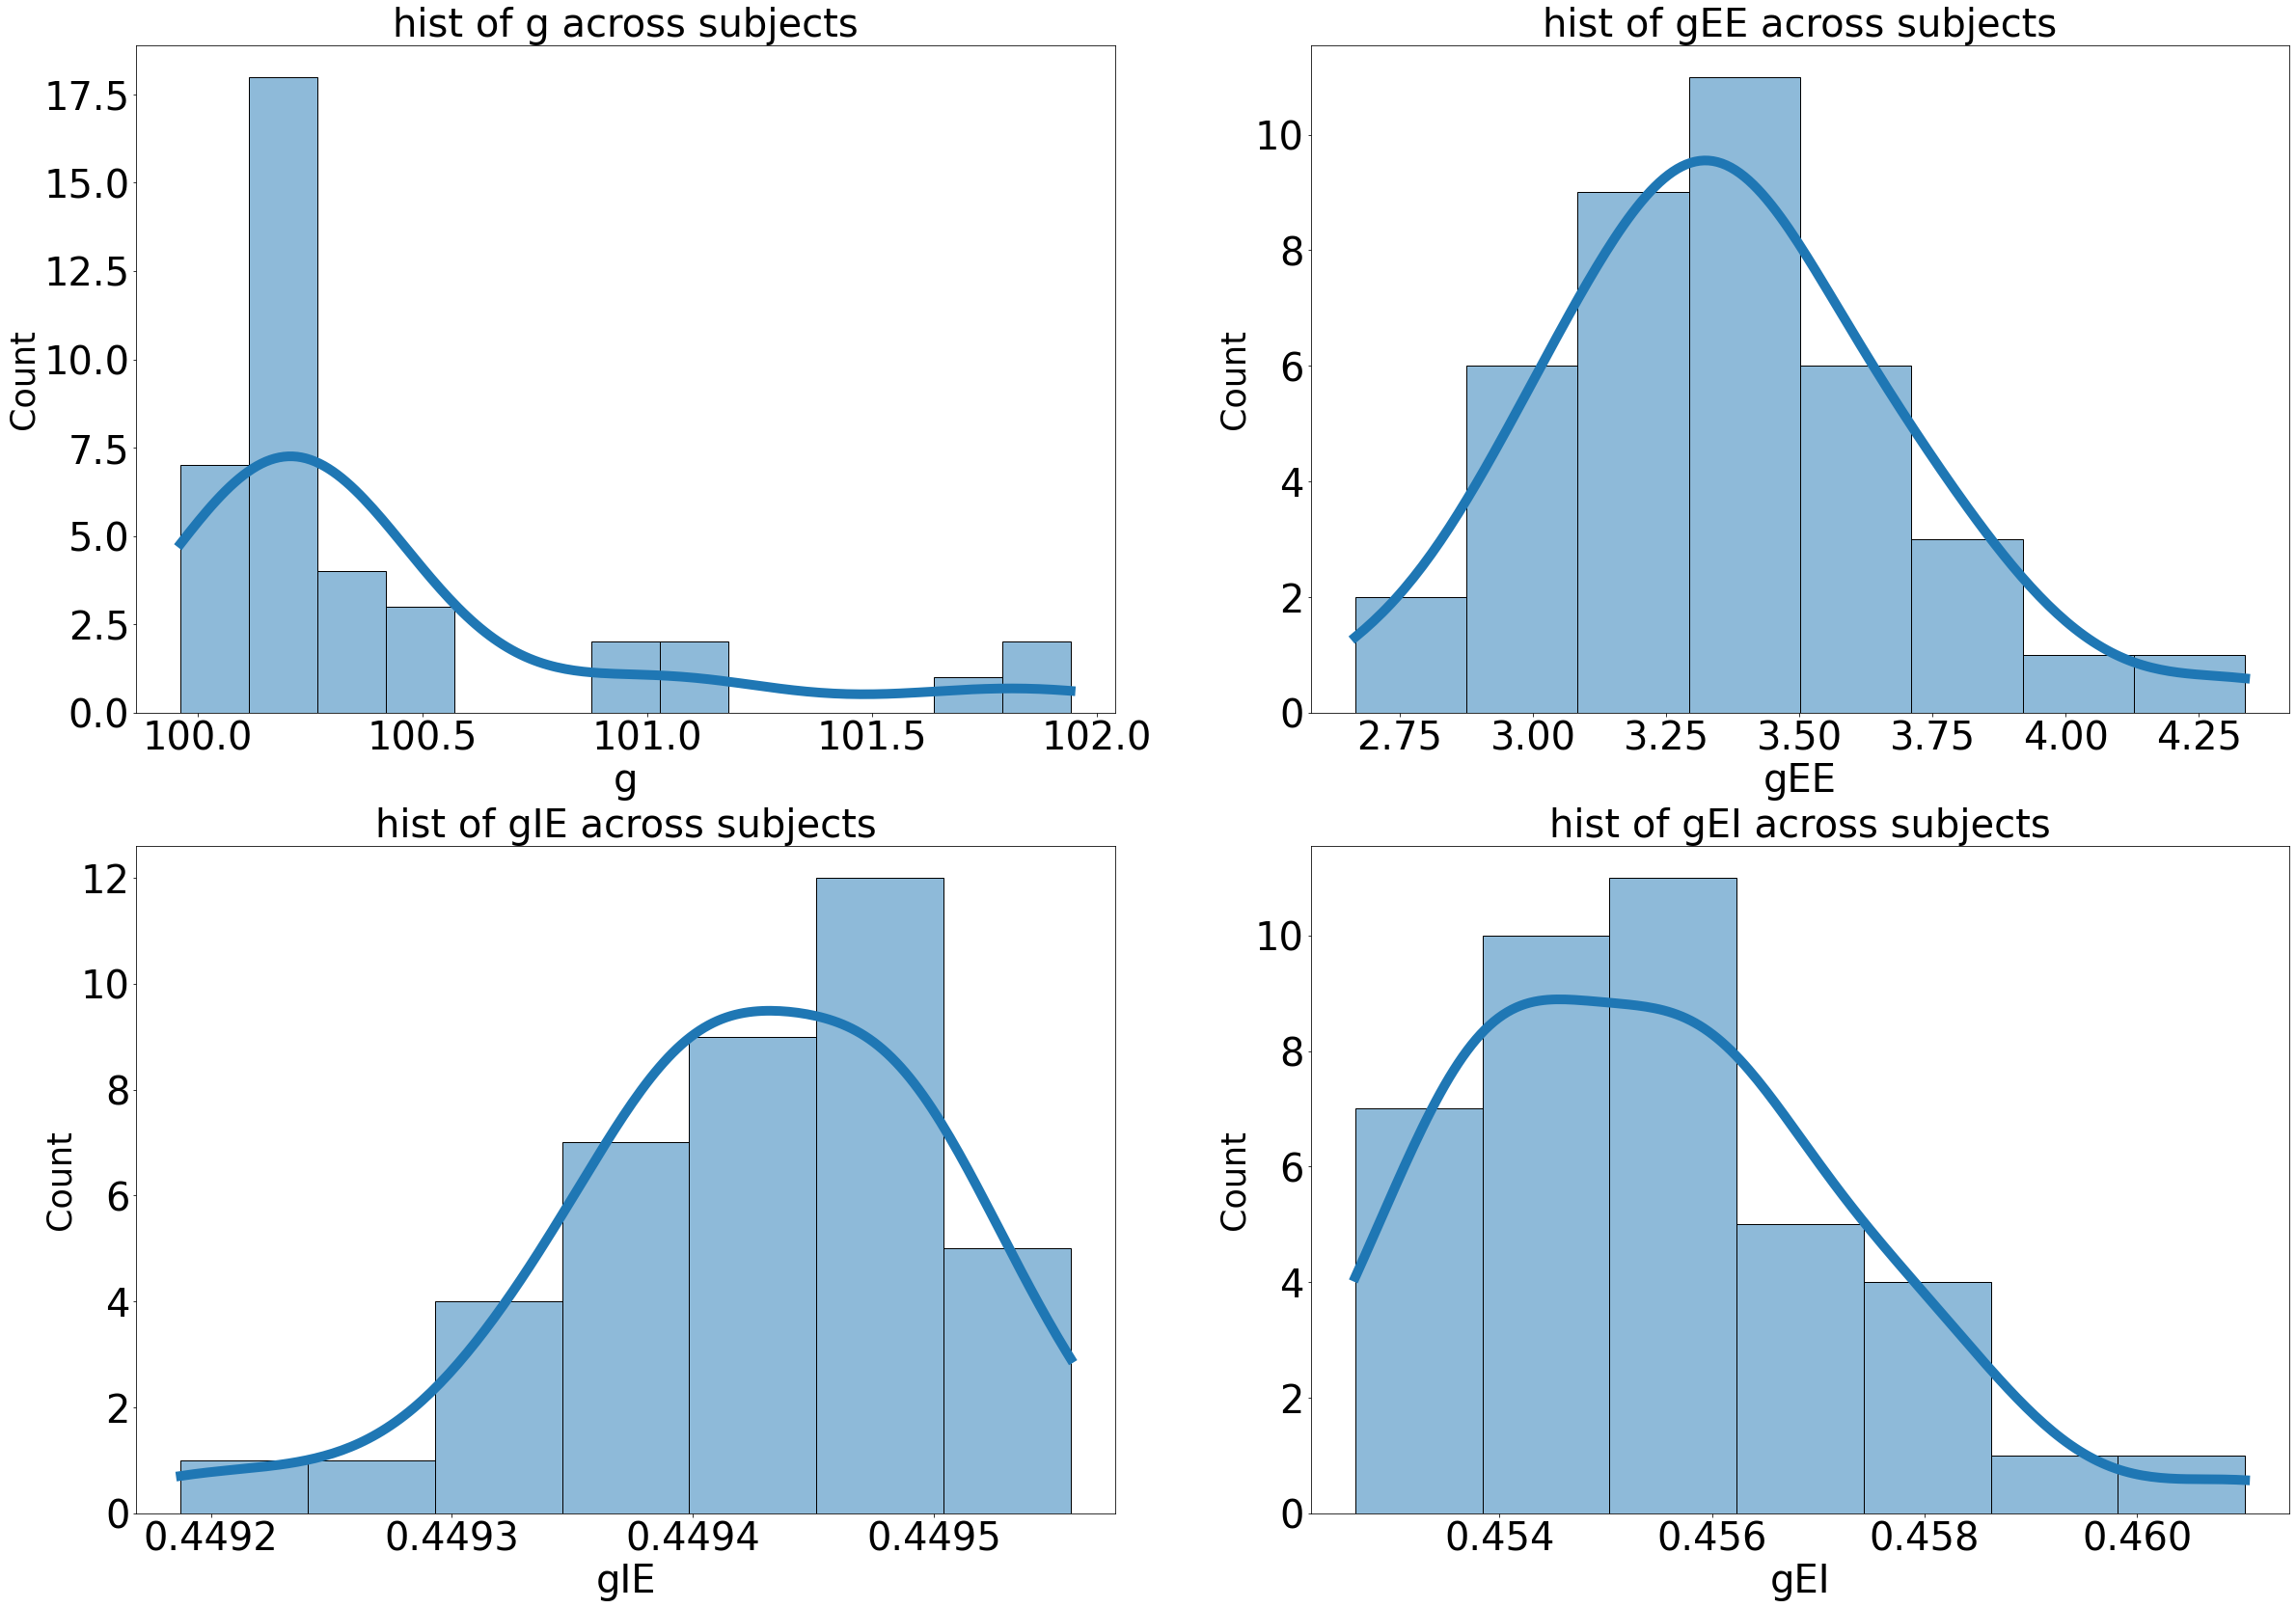

In [19]:
fig, ax = plt.subplots(2,2, figsize=(40,28))

mask = np.tril_indices(66,-1)
data_dict = {}
data_dict['g'] = []
data_dict['gEE'] = []
data_dict['gIE'] = []
data_dict['gEI'] = []

para_name = ['g', 
             'gEE', 
             'gIE', 
             'gEI']

for sub in Syn_paras:
    
    data_dict['g'].append(Syn_paras[sub][0].mean())
    data_dict['gEE'].append(Syn_paras[sub][1].mean())
    data_dict['gIE'].append(Syn_paras[sub][2].mean())
    data_dict['gEI'].append(Syn_paras[sub][3].mean())
    
data_dict['g'] = np.array(data_dict['g'])
data_dict['gEE'] = np.array(data_dict['gEE'])
data_dict['gIE'] = np.array(data_dict['gIE'])
data_dict['gEI'] = np.array(data_dict['gEI'])

for i in range(4):
    sns.histplot(ax=ax[i//2, i%2], data=data_dict[para_name[i]], kde=True, line_kws={'linewidth':10})
    ax[i//2, i%2].set_title('hist of ' + para_name[i] +' across subjects', fontsize='40')
    ax[i//2, i%2].tick_params(labelsize=40)
    ax[i//2, i%2].set_xlabel(para_name[i], fontsize=40)
  
plt.show()
# fig.savefig(base_dir+'Syn_hist_modelparas.png')

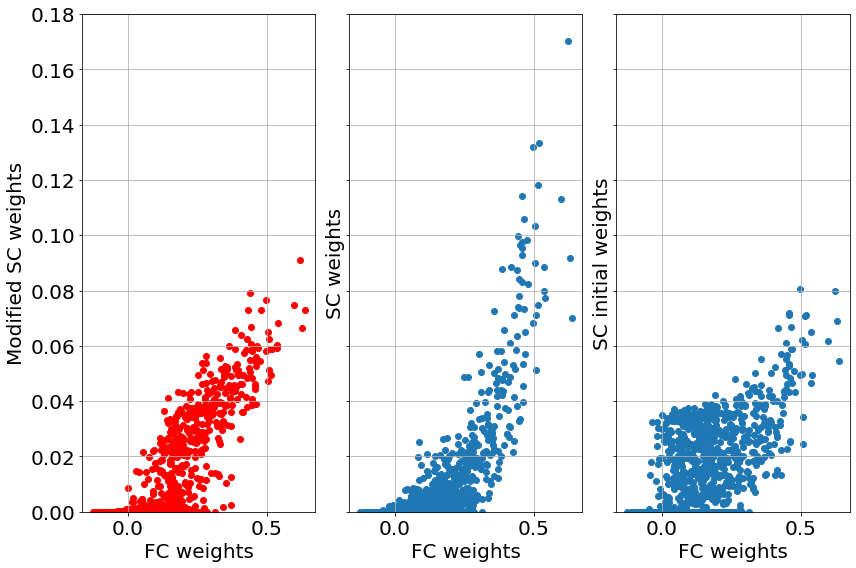

In [20]:

sc_m = Syn_sc_mod[sub]

fig, ax = plt.subplots(1,3, figsize=(12,8), sharex=True, sharey=True)
ax[0].scatter(fc_true[mask], sc_m[mask], c='r')
#ax[0].set_title('The modified SC against FC in elements', fontsize=20)
ax[0].tick_params(labelsize = 20)
ax[0].set_xlabel('FC weights', fontsize = 20)
ax[0].set_ylabel('Modified SC weights', fontsize = 20)
ax[0].set_ylim(0,0.18)
ax[1].scatter(fc_true[mask], sc_true[mask])
#ax[1].set_title('The SC against FC in elements', fontsize=20)
ax[1].set_ylim(0,0.18)
ax[1].tick_params(labelsize = 20)
ax[1].set_xlabel('FC weights', fontsize = 20)
ax[1].set_ylabel('SC weights', fontsize = 20)
ax[2].scatter(fc_true[mask], Syn_sc[sub][mask])
#ax[2].set_title('The initial SC against FC in elements', fontsize=20)
ax[2].set_ylim(0,0.18)
ax[2].tick_params(labelsize = 20)
ax[2].set_xlabel('FC weights', fontsize = 20)
ax[2].set_ylabel('SC initial weights', fontsize = 20)
ax[0].grid()
ax[1].grid()
ax[2].grid()

fig.tight_layout()
plt.show()

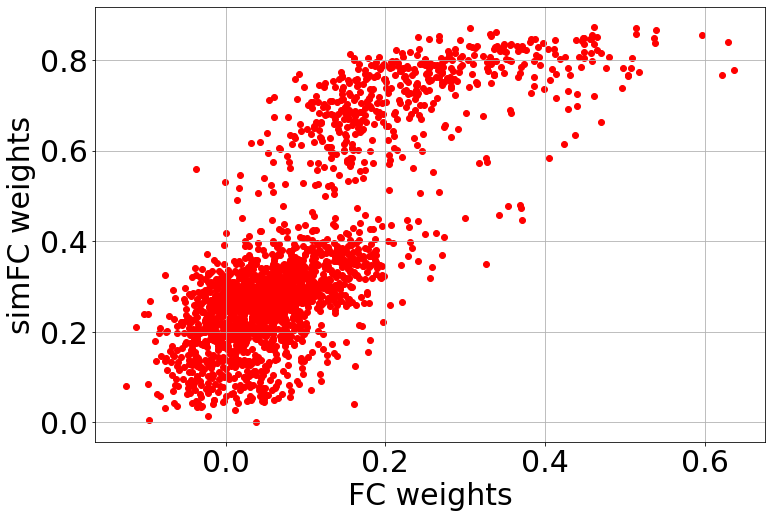

In [21]:

sub = 'sub_25'

sc = Syn_sc[sub]
sc_m = Syn_sc_mod[sub]
fig, ax = plt.subplots(1,1, figsize=(12,8))
ax.scatter(fc_true[mask], np.corrcoef(Syn_ts_sim[sub])[mask], c='r')
#ax.set_title('The simulated FC against FC in elements',fontsize=20)
ax.tick_params(labelsize=30)
ax.set_xlabel('FC weights', fontsize=30)
ax.set_ylabel('simFC weights', fontsize=30)
ax.grid()
#ax.set_ylim(0,0.18)

## Correlation matrix of parameter fitting 

This matrix shows the correlation coefficients for the coupling strength parameters.

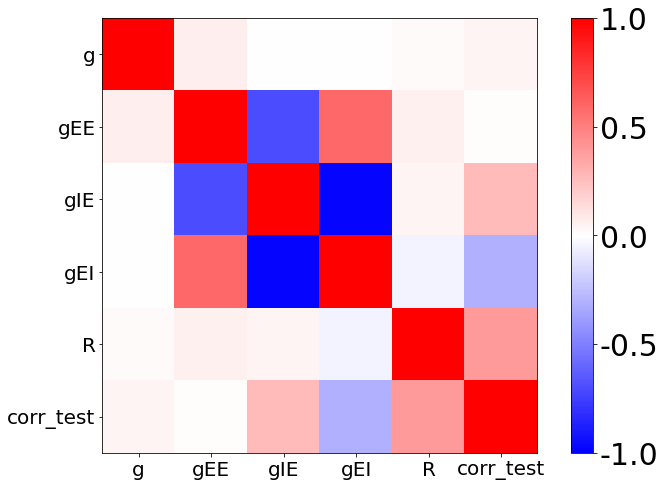

In [22]:
start_time = time.time()
fig, ax = plt.subplots(1,1, figsize=(12,8))

mask = np.tril_indices(66,-1)
data_dict = {}
data_dict['g'] = []
data_dict['gEE'] = []
data_dict['gIE'] = []
data_dict['gEI'] = []
"""data_dict['cA'] = []
data_dict['cB'] = []
data_dict['cC'] = []"""
data_dict['R'] = []
data_dict['corr_test'] = []
para_name = ['g', 
             'gEE', 
             'gIE', 
             'gEI', 
             'R', 'corr_test']#'cA', 'cB', 'cC', 
for sub in Syn_paras:
    
    data_dict['g'].append(Syn_paras[sub][0].mean())
    data_dict['gEE'].append(Syn_paras[sub][1].mean())
    data_dict['gIE'].append(Syn_paras[sub][2].mean())
    data_dict['gEI'].append(Syn_paras[sub][3].mean())
    """data_dict['cA'].append(HCP_para[sub][-10:,4].mean())
    data_dict['cB'].append(HCP_para[sub][-10:,5].mean())
    data_dict['cC'].append(HCP_para[sub][-10:,6].mean())"""
    data_dict['R'].append(np.corrcoef(fc_true[mask], np.corrcoef(Syn_ts_sim[sub][:,10:])[mask])[0,1])
    data_dict['corr_test'].append(np.corrcoef(fc_true[mask], np.corrcoef(Syn_ts_test[sub])[mask])[0,1])
data_dict['g'] = np.array(data_dict['g'])
data_dict['gEE'] = np.array(data_dict['gEE'])
data_dict['gIE'] = np.array(data_dict['gIE'])
data_dict['gEI'] = np.array(data_dict['gEI'])

"""data_dict['cA'] = np.array(data_dict['cA'])
data_dict['cB'] = np.array(data_dict['cB'])
data_dict['cC'] = np.array(data_dict['cC'])"""
data_dict['R'] = np.array(data_dict['R'])

data_dict['corr_test'] = np.array(data_dict['corr_test'])

corr_paras = np.zeros((len(data_dict), len(data_dict)))
for i in range(len(data_dict)):
    for j in range(len(data_dict)):
        corr_paras[i,j] = np.corrcoef(data_dict[para_name[i]], data_dict[para_name[j]])[0,1]

im = ax.imshow(corr_paras, cmap='bwr', vmin=-1)
ax.set_xticklabels(['0' ] + para_name, fontsize=30)
ax.set_yticklabels( ['0'] + para_name, fontsize=30)
ax.tick_params(labelsize=20)

cbar = fig.colorbar(im, ax=ax)
cbar.ax.tick_params(labelsize=30)
cbar.set_ticks([-1.0, -0.5, 0.0, 0.5, 1.0])
cbar.set_ticklabels([-1.0, -0.5, 0.0, 0.5, 1.0])
plt.show()
# fig.savefig(base_dir+'Syn_corr_modelparas+fit.png')

## Distribution convergence analysis

The degree of convergence of a random Markov Chain can be estimated using the Gelman-Rubin convergence statistic, $\hat{R}$, based on the stability of outcomes between and within $m$ chains of the same length, $n$. Values close to one indicate convergence to the underlying distribution. Values greater than 1.1 indicate inadequate convergence.

In [24]:
def R_stat(data):
    """
    Calculate the Gelman-Rubin convergence statistic, R-hat. 

    Parameters
    ----------
    data: input data dictionary for parameter value
    """
    ###B step 1 variance of mean of m chains
    num_data = data.shape[1]
    num_param = data.shape[2]
    num_chain = data.shape[0]
    var_chs =  num_data* data.mean(1).std(0)**2
    
    ### step 2. the average of variance of m chains W
    m_var_chs = (data.std(1)**2).mean(0)
    
    ### step 3 target of mean: mean of 4*datapoints 
    m_target = data.mean(1).mean(0)
    
    #### step 4 estimate of target variance
    v_target = (num_data-1.0)/num_data*m_var_chs + 1.0/num_data*var_chs
    
    #### step 5 
    V_hat = v_target + var_chs/num_chain/num_data
    v_var = (data.std(1)**2).std(0)**2
    v_V_hat = (num_data/(num_data- 1.0))**2/num_chain*v_var + ((num_chain+1.0)/num_chain/num_data)**2*2/(num_chain -1.0)*var_chs**2 +\
              2*(num_chain + 1.0 )*(num_data- 1.0)/num_chain/num_data/num_chain*(np.diag(np.cov((data.std(1)**2).T,\
              (data.mean(1)**2).T)[:num_param,:][:,num_param:])\
              - 2*m_target*np.diag(np.cov((data.std(1)**2).T, data.mean(1).T)[:num_param,:][:,num_param:]))
    df = 2.0*V_hat**2/v_V_hat
    
    ### R
    R = V_hat/m_var_chs*df/(df-2.0)
    
    return R

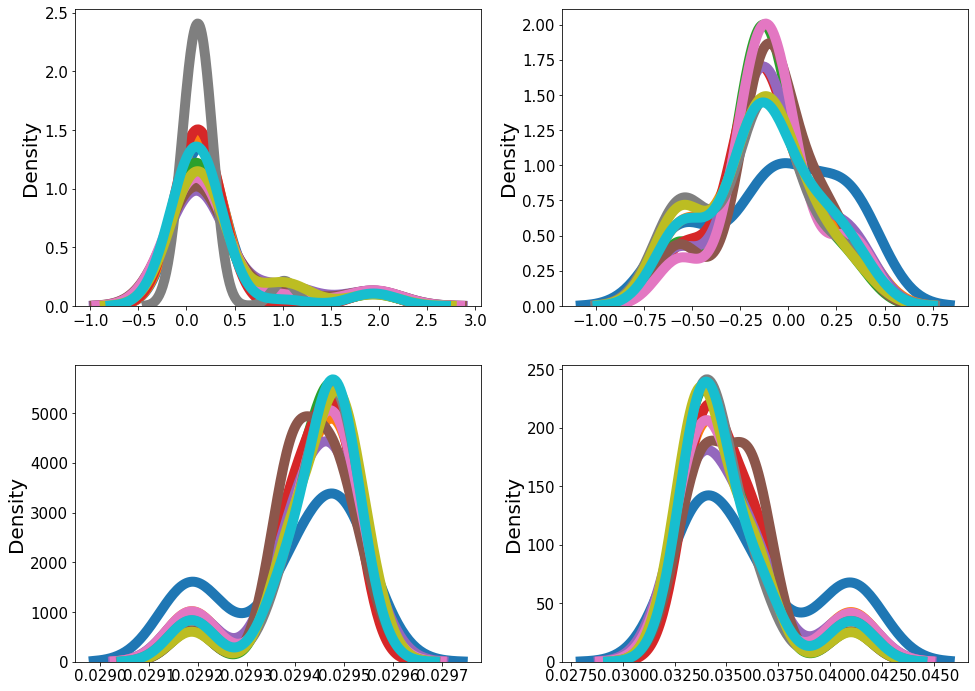

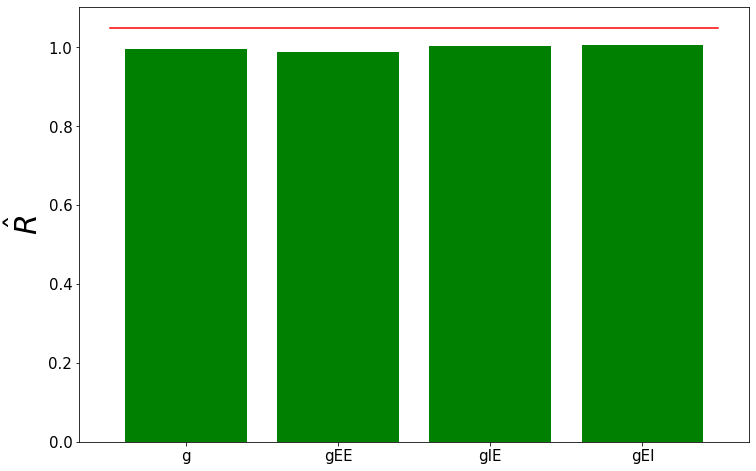

In [25]:
start_time = time.time()
fig, ax = plt.subplots(2,2, figsize=(16,12))
plt.rcParams["axes.labelsize"] = 20
mask = np.tril_indices(66,-1)
data_dict = {}
data_max = {}
data_dict['g'] = []
data_dict['gEE'] = []
data_dict['gIE'] = []
data_dict['gEI'] = []

data_max['g'] = []
data_max['gEE'] = []
data_max['gIE'] = []
data_max['gEI'] = []

para_name = ['g', 
             'gEE', 
             'gIE', 
             'gEI']

data_chains = []


for j in range(10):
    data_dict['g'] = []
    data_dict['gEE'] = []
    data_dict['gIE'] = []
    data_dict['gEI'] = []

    data_max['g'] = []
    data_max['gEE'] = []
    data_max['gIE'] = []
    data_max['gEI'] = []

    numID=np.random.choice(np.arange(10), size= 30)
    subs = ['sub_'+str(num) for num in numID]
    for sub in subs:
        
        data_max['g'].append(max(np.abs(Syn_paras[sub][0].mean()), 100))
        data_max['gEE'].append(max(np.abs(Syn_paras[sub][1].mean()), 3.5))
        data_max['gIE'].append(max(np.abs(Syn_paras[sub][2].mean()), 0.42))
        data_max['gEI'].append(max(np.abs(Syn_paras[sub][3].mean()), 0.42))

    for sub in subs:
        
        data_dict['g'].append((Syn_paras[sub][0].mean() - 100))#/max(data_max['g']))
        data_dict['gEE'].append((Syn_paras[sub][1].mean() - 3.5))#/max(data_max['gEE']))
        data_dict['gIE'].append((Syn_paras[sub][2].mean() - 0.42))#/max(data_max['gIE']))
        data_dict['gEI'].append((Syn_paras[sub][3].mean() - 0.42))#/max(data_max['gEI']))
        
    data_dict['g'] = np.array(data_dict['g'])
    data_dict['gEE'] = np.array(data_dict['gEE'])
    data_dict['gIE'] = np.array(data_dict['gIE'])
    data_dict['gEI'] = np.array(data_dict['gEI'])
    data_chains.append(np.array(list(data_dict.values())).T)

    for i in range(4):
        sns.kdeplot(ax=ax[i//2, i%2], data=data_dict[para_name[i]], linewidth=10)
        #ax[i//2, i%2].set_title('hist of error of ' + para_name[i] +' across subjects', fontsize = 20)
        #ax[i//2, i%2].set_xlim(-0.25,0.25)
        ax[i//2, i%2].tick_params(labelsize = 15)

plt.show()
# fig.savefig(base_dir + 'Syn_hist_10chains_withgains.png')

R_stat(np.array(data_chains))
fig, ax = plt.subplots(1, 1, figsize=(12,8))
ax.bar(para_name, R_stat(np.array(data_chains)), color='g')
ax.plot(np.linspace(-0.5, 3.5, 50), 1.05*np.ones((50,)), c='r')
ax.set_ylabel('$\hat{R}$', fontsize=30)
ax.tick_params(labelsize=15)
plt.show()
# fig.savefig(base_dir + 'Syn_R_stat_withgains.png')

In [26]:
end_time =  time.time()
print('running time is  {0} \'s'.format(end_time - start_time ))

running time is  1.9630208015441895 's
